# Кластеризация

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *

## Подготовка данных

Данные – пересказы сюжетов 100 лучших фильмов всех времен по версии imdb. Для каждого из них известен набор жанров – но насколько они отражают действительность?

In [2]:
movies = pd.read_csv('../../clustering/movie_synopses.csv', sep='\t', \
                     encoding='utf-8', quotechar='"', escapechar='\\')
movies.head()

,synopsis,title,genre
0,"In late summer 1945, guests are gathered for t...",The Godfather,"Crime, Drama"
1,"In 1947, Andy Dufresne (Tim Robbins), a banker...",The Shawshank Redemption,"Crime, Drama"
2,The relocation of Polish Jews from surrounding...,Schindler's List,"Biography, Drama, History"
3,"The film opens in 1964, where an older and fat...",Raging Bull,"Biography, Drama, Sport"
4,"In the early years of World War II, December 1...",Casablanca,"Drama, Romance, War"


In [3]:
data = [s.lower() for s in movies.synopsis]
data = [re.sub(r'[,.\'–?!;:"()]', '', s) for s in data]
data[5][:300]

'in 1963 oregon randle patrick mcmurphy nicholson a criminal who has been sentenced to a fairly short prison term decides to have himself declared insane so hell be transferred to a mental institution where he expects to serve the rest of his term free of prison labor and in comparative comfort and l'

## Кластеризация

Некоторые алгоритмы кластеризации ([вот очень хорошее описание](https://scikit-learn.org/stable/modules/clustering.html#clustering) из документации `sklearn`):

* [K-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
* [Mini-Batch K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans)
* [Spectral Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering)
* [Hierarchical Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
* [Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation)
* [MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift)
* [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)


![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)


### Что входит в Pipeline
* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) – векторизация
    * max_df – максимальная документная частота 
    * max_features – максимальное количество признаков
    * min_df – минимальная документная частота
    * ngram_range – интервал для $n$-грам
    * analyzer –  задает элемент текста {‘word’, ‘char’, ‘char_wb’}  
    * stop_words – стоп-слова
* [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) – $tf-idf$ преобразование
    * можно не использовать
* [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) – сингулярное разложение
    * можно не использовать
    * n_components – число компонент
    * для визуализации результатов, нужно обязательно снизить размерность до 2, можно также использовать метод главных компонент ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))
* [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) – нормировка (сумма по столбцу будет равна 1)
    * можно не использовать
* Последний этап – какой-либо алгоритм кластеризации, см. выше (можно выбрать любой, в примере ниже – KMeans)

Необязательно включать все этапы в пайплайн, можно выполнять их и по-отдельности. 

**NB!** Все ссылки ведут на документацию `sklearn`.

In [4]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.8, min_df=5, ngram_range=(1,3), \
                             analyzer='word', stop_words ='english')),
    ('tfidf', TfidfTransformer())
])

X = pipeline.fit_transform(data)
X.shape

(100, 2348)

## K-Means

Какое количество кластеров взять? Первая идея – по количеству возможных жанров, но их около 20, что многовато для 100 фильмов. К тому же, почти у всех фильмов по несколько жанров, так что смело можно сократить количество кластеров как минимум пополам, а то и в 4 раза.

In [13]:
n_clusters = 5

clf = KMeans(n_clusters=n_clusters)
result = clf.fit_predict(X)

In [14]:
# добавим номера кластеров в датасет для удобства

movies['cluster'] = result
movies.head()

,synopsis,title,genre,cluster
0,"In late summer 1945, guests are gathered for t...",The Godfather,"Crime, Drama",2
1,"In 1947, Andy Dufresne (Tim Robbins), a banker...",The Shawshank Redemption,"Crime, Drama",3
2,The relocation of Polish Jews from surrounding...,Schindler's List,"Biography, Drama, History",2
3,"The film opens in 1964, where an older and fat...",Raging Bull,"Biography, Drama, Sport",2
4,"In the early years of World War II, December 1...",Casablanca,"Drama, Romance, War",1


Какие фильмы входят в каждый из кластеров?

In [15]:
for i in range(n_clusters):
    print("Cluster %d:\n%s\n" % \
          (i, movies.loc[movies['cluster'] == i, 'title'].tolist()))

Cluster 0:
['Citizen Kane', 'Rebel Without a Cause']

Cluster 1:
['Casablanca', 'Gone with the Wind', '2001: A Space Odyssey', '12 Angry Men', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb', 'Apocalypse Now', 'The Lord of the Rings: The Return of the King', 'Gladiator', 'Saving Private Ryan', 'Unforgiven', 'Raiders of the Lost Ark', 'Butch Cassidy and the Sundance Kid', 'The Treasure of the Sierra Madre', 'Platoon', 'Dances with Wolves', 'Taxi Driver', 'All Quiet on the Western Front', 'High Noon', 'Shane', 'Stagecoach']

Cluster 2:
['The Godfather', "Schindler's List", 'Raging Bull', 'The Godfather: Part II', 'Forrest Gump', 'The Sound of Music', 'West Side Story', 'E.T. the Extra-Terrestrial', 'Gandhi', 'A Streetcar Named Desire', 'The Philadelphia Story', 'To Kill a Mockingbird', 'The Best Years of Our Lives', 'Doctor Zhivago', 'Patton', 'The Apartment', 'The Pianist', 'Goodfellas', 'The Deer Hunter', "The King's Speech", 'Tootsie', 'Giant', 'The Grapes of Wr

Соотносится ли это с жанрами? Спойлер: не особенно...

In [16]:
for i in range(n_clusters):
    print("Cluster %d:\n%s\n" % \
          (i, movies.loc[movies['cluster'] == i, 'genre'].tolist()))

Cluster 0:
['Drama, Mystery', 'Crime, Drama, Thriller']

Cluster 1:
['Drama, Romance, War', 'Drama, Romance, War', 'Mystery, Sci-Fi', 'Drama', 'Comedy, War', 'Drama, War', 'Adventure, Fantasy', 'Action, Drama', 'Action, Drama, War', 'Western', 'Action, Adventure', 'Biography, Crime, Western', 'Action, Adventure, Drama, Western', 'Drama, War', 'Western', 'Comedy, Drama, Romance', 'Crime, Drama, Sci-Fi', 'Drama, Romance', 'Crime, Drama, Film-Noir, Thriller', 'Film-Noir, Mystery, Thriller']

Cluster 2:
['Crime, Drama', 'Biography, Drama, History', 'Biography, Drama, Sport', 'Crime, Drama', 'Drama, Romance', 'Biography, Drama, Family, Musical, Romance', 'Crime, Drama, Musical, Romance, Thriller', 'Adventure, Family, Sci-Fi', 'Biography, Drama, History', 'Drama', 'Comedy, Romance', 'Drama', 'Drama, Romance, War', 'Drama, Romance, War', 'Biography, Drama, War', 'Comedy, Drama, Romance', 'Adventure, Drama, Western', 'Biography, Drama, War', 'Horror', 'Drama, War', 'Comedy, Drama, Romance', 'D

## Визуализация

Чтобы визуализировать результаты, нужно снизить размерность данных до 2 – например, с помощью PCA.

In [17]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X.todense())
centers = pca.fit_transform(clf.cluster_centers_)

### Matplotlib

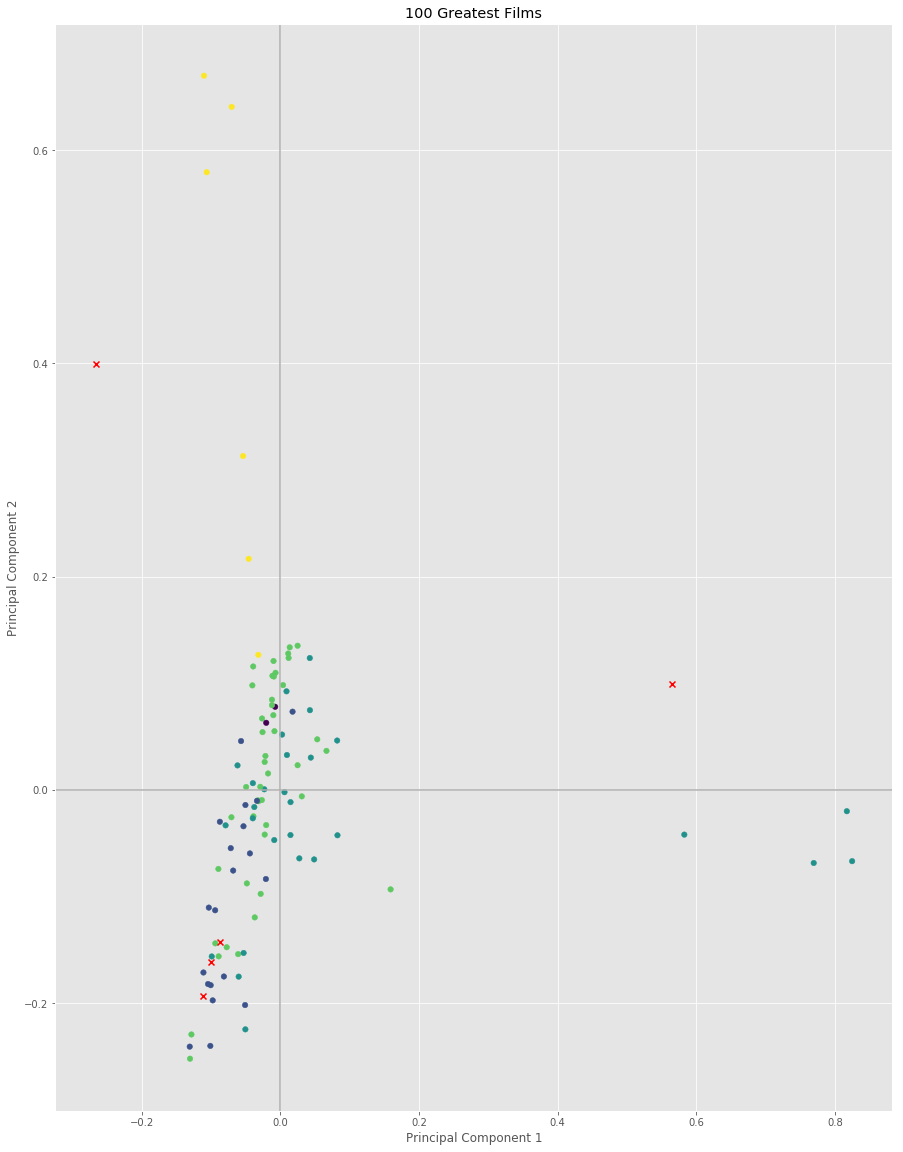

In [18]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

plt.figure(figsize = (15,20))
plt.axhline(0, color='#afafaf')
plt.axvline(0, color='#afafaf')

for i in range(n_clusters):
    try:
        plt.scatter(X_2D[i:,0], X_2D[i:,1], s=30, c=clf.labels_)
    except (KeyError, ValueError) as e: # костыль для бага матплотлиба
        pass

plt.scatter(centers[:,0], centers[:,1], marker="x", c='r')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('100 Greatest Films')
plt.show()

### Plotly

Красивая динамическая визуализация, которую не рендерит ни GitHub, ни colab – можно посмотреть только запустив у себя.

In [42]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True)

points = go.Scatter(
        x = X_2D[:,0],
        y = X_2D[:,1],
        name = 'Movies', 
        mode='markers',
        marker=dict(color=clf.labels_, colorscale='Viridis', size=10),
        text=movies['title'].tolist(),
        textposition='bottom right'
)


center_points = go.Scatter(
         x = centers[:,0], 
         y = centers[:,1], 
         mode = 'markers', 
         marker = dict(size=10, color='red', symbol='cross'),
         name = 'Centroids'
)


fig = tools.make_subplots(rows=1, cols=1)

fig.append_trace(points, 1, 1)
fig.append_trace(center_points, 1, 1)

fig['layout'].update(
                     title={'text': '100 Greatest Films', 'font': {'size': 25}}, 
                     xaxis={'title':'Principal Component 1'}, 
                     yaxis={'title':'Principal Component 2'},
                     legend={'font': {'size': 20},
                             'bgcolor':'#f6f6f6'})
            
iplot(fig, filename='film_synopses_clustering')

This is the format of your plot grid:
[ (1,1) x1,y1 ]



## Оценка качества

Измерить качество по одной из следующих метрик можно только если известны настоящие метки документов. В нашем случае это не так, поэтому просто сгенерируем их – для интерпретации качества смысла никакого, зато понятно, как работают метрики. То же самое касается и [матрицы ошибок](https://www.python-course.eu/confusion_matrix.php).

* [Homogenity Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score)
* [Completeness Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)
* [V-Measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score)
* [Adjusted Rand-Index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)
* [Adjusted Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score)

In [21]:
target = np.random.randint(0,5, size=100)

print("Homogeneity:", homogeneity_score(target, clf.labels_))
print("Completeness:", completeness_score(target, clf.labels_))
print("V-measure",  v_measure_score(target, clf.labels_))
print("Adjusted Rand-Index:",  adjusted_rand_score(target, clf.labels_))
print("Adjusted Mutual Information:",  adjusted_mutual_info_score(target, clf.labels_))

Homogeneity: 0.04119291344816716
Completeness: 0.05136875767391293
V-measure 0.04572149061592733
Adjusted Rand-Index: -0.010257885150033575
Adjusted Mutual Information: -0.014751611745389128


C:\Users\ancatmara\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



#### Матрица ошибок

Строки – настоящая метка, столбцы – предсказанная. Т.е. в левом верхнем углу документы из кластера 0, которые были определены как 0, следующая ячейка в этой строке – документы класса 0, предсказанные как 1 и т.п. В каждом квадратике показано число соответствующих примеров, и чем больше их, тем темнее цвет.

**NB!** В данном случае "настоящие метки" сгенерированы искусственно, поэтому интерпретировать картинку с точки зрения здравого смысла – бессмысленно.

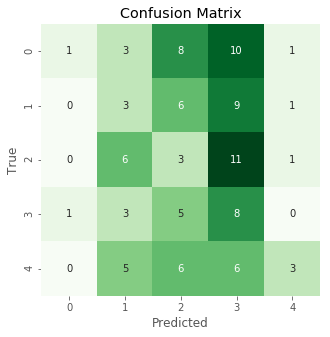

In [22]:
import seaborn as sns

m = confusion_matrix(target, clf.labels_)

plt.figure(figsize = (5,5))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Идеальная матрица ошибок – диагональная.

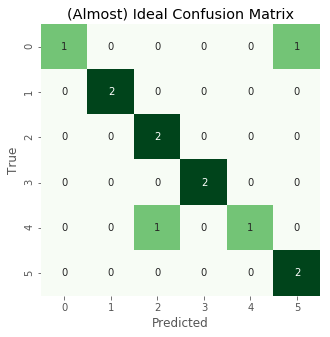

In [23]:
plt.figure(figsize = (5,5))
sns.heatmap(data=confusion_matrix([0,1,2,3,4,5,0,1,2,3,4,5], [5,1,2,3,4,5,0,1,2,3,2,5]), 
            annot=True, fmt="d", cbar=False, cmap="Greens")
plt.title("(Almost) Ideal Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Agglomerative Clustering

Другой алгоритм на уже подготовленных данных.

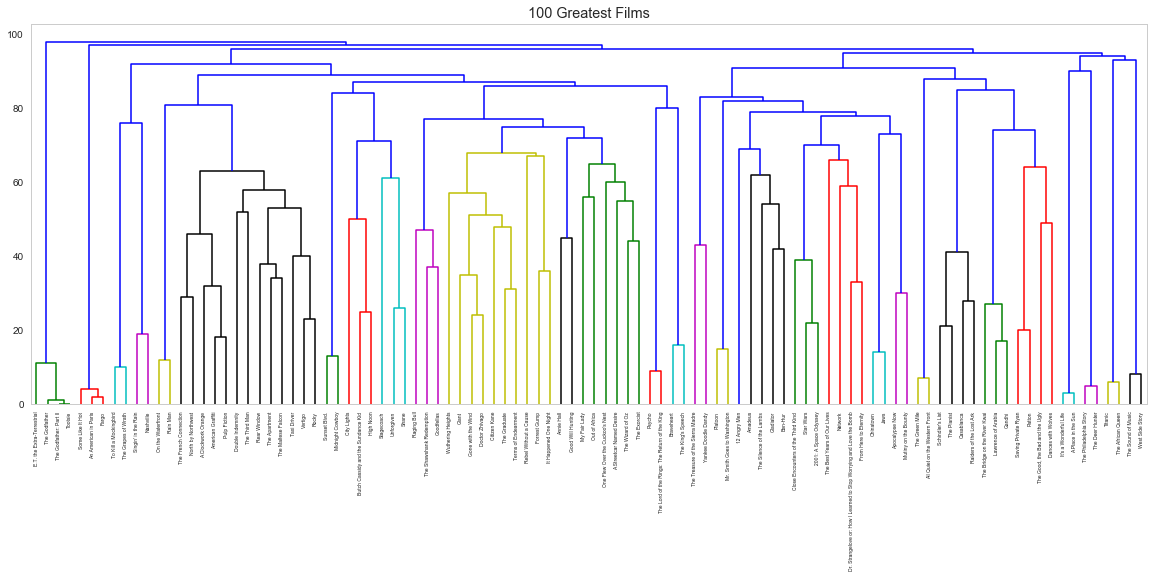

In [25]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

clf2 = AgglomerativeClustering()
clf2.fit(X.toarray())

sns.set_style(style='whitegrid')
plt.figure(figsize = (20,7))
plt.grid(False)
plt.title('100 Greatest Films')
plot_dendrogram(clf2, labels=movies['title'].tolist())
plt.show()

В plotly тоже есть дендрограммы, в которые уже зашита кластеризация. Но их, как и предыдущий график из plotly, просто так не увидишь.

In [26]:
import plotly.figure_factory as ff

X_2D = pca.fit_transform(X.todense())
dendro = ff.create_dendrogram(X_2D, labels=movies['title'].tolist())
dendro['layout'].update(width=1000, height=500,
                     title={'text': '100 Greatest Films', 'font': {'size': 25}}, 
                     font={'size': 10})
iplot(dendro, filename='simple_dendrogram')

## t-SNE

**t-SNE** _(t-distributed stochastic neighbor embedding)_ — техника нелинейного снижения размерности и визуализации многомерных переменных. Документация [тут](http://www.scikit-yb.org/en/latest/api/text/tsne.html).

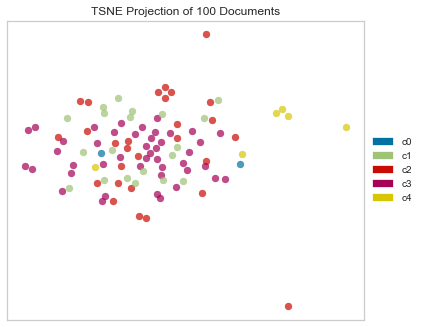

In [46]:
import yellowbrick
from yellowbrick.text import TSNEVisualizer

# В X все еще лежит векторизованный корпус размерностью 2348
tsne = TSNEVisualizer()
tsne.fit(X, ["c{}".format(c) for c in clf.labels_])
tsne.poof()